# **Chapter 10 – Introduction to Artificial Neural Networks**

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Perceptron
### Sciket-learn提供单一LTU（线性阈值单元）网络

In [2]:
#感知器学习算法类似于随机梯度下降。事实上，sklearn 的感知器类相当于使用具有以下超参数的 SGD 分类器：
#loss="perceptron"，learning_rate="constant"（学习率），eta0=1，penalty=None（无正则化）。

#注意，与逻辑斯蒂回归分类器相反，感知机不输出类概率，而是基于硬阈值进行预测。
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
iris=load_iris()
X = iris.data[:, (2, 3)] 
y=(iris.target==0).astype(np.int)#是否Setosa
per_clf=Perceptron(random_state=42)
per_clf.fit(X,y)
y_pred=per_clf.predict([[2,0.5]])      #输入必须是二位数组  [[x1,x2]]
y_pred

H:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([1])

In [12]:
#  g(x) = w1x1 + w2x2 + w0
print(-per_clf.coef_)
print(per_clf.intercept_)

[[ 1.1  1.2]]
[ 3.]


In [34]:
a = -per_clf.coef_[0][0]/per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes=[0,5,0,2]
x0,x1=np.meshgrid(
    np.linspace(axes[0],axes[1],500).reshape(-1,1),
    np.linspace(axes[2],axes[3],200).reshape(-1,1),
)
print(x0.shape)
print(x1.shape)
x0#行与行相同，列从0到5
x1#列于列相同，行从0到2
X_new = np.c_[x0.ravel(), x1.ravel()]#ravel变成一列，再按列合并
print(x1.ravel().shape)
print(X_new.shape)
X_new
y_predict=per_clf.predict(X_new)
print(y_predict.shape)             #100000*1
zz=y_predict.reshape(x0.shape)     #200*500

(200, 500)
(200, 500)
(100000,)
(100000, 2)
(100000,)


Saving figure perceptron_iris_plot


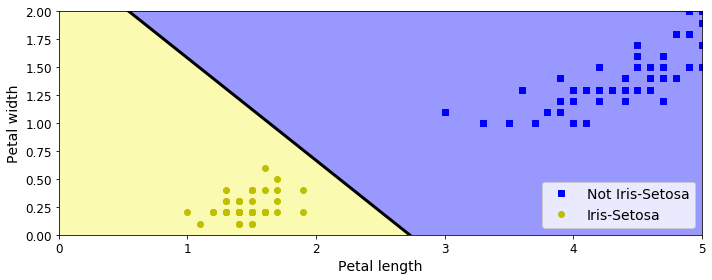

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

Saving figure activation_functions_plot


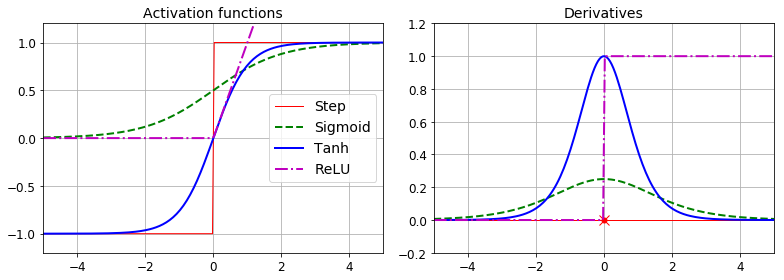

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# FNN for MNIST
## Using the Estimator API (formerly tf.contrib.learn)

Warning: tf.examples.tutorials.mnist is deprecated. We will use tf.keras.datasets.mnist instead. Moreover, the tf.contrib.learn API was promoted to tf.estimators and tf.feature_columns, and it has changed considerably. In particular, there is no infer_real_valued_columns_from_input() function or SKCompat class.

In [4]:
import tensorflow as tf
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

In [5]:
X_train=X_train.astype(np.float32).reshape(-1,28*28)/255.0
print(X_train.shape)
X_test=X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_train=y_train.astype(np.int32)
y_test=y_test.astype(np.int32)
X_valid,X_train=X_train[:5000],X_train[5000:]
y_valid,y_train=y_train[:5000],y_train[5000:]

(60000, 784)


In [56]:
feature_cols=[tf.feature_column.numeric_column("X",shape=[28*28])]
dnn_clf=tf.estimator.DNNClassifier(hidden_units=[300,100],n_classes=10,feature_columns=feature_cols,model_dir="./model")
input_fn=tf.estimator.inputs.numpy_input_fn(
    x={"X":X_train},y=y_train,num_epochs=10,batch_size=50,shuffle=True)
dnn_clf.train(input_fn=input_fn,steps=3000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_task_id': 0, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022D32260080>, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_num_worker_replicas': 1, '_evaluation_master': '', '_device_fn': None, '_is_chief': True, '_num_ps_replicas': 0, '_task_type': 'worker', '_service': None, '_train_distribute': None, '_master': '', '_save_checkpoints_steps': None, '_model_dir': './model', '_save_summary_steps': 100, '_keep_checkpoint_max': 5}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model\model.ckpt.
INFO:tensorflow:loss =

In [52]:
feature_cols

[_NumericColumn(key='X', shape=(784,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [53]:
input_fn

<function tensorflow.python.estimator.inputs.numpy_io.numpy_input_fn.<locals>.input_fn>

In [57]:
#评估
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)
eval_results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-22-07:19:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-22-07:19:20
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.9715, average_loss = 0.0883222, global_step = 3000, loss = 11.18
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: ./model\model.ckpt-3000


{'accuracy': 0.97149998,
 'average_loss': 0.088322207,
 'global_step': 3000,
 'loss': 11.180026}

In [65]:
#预测
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
#y_pred_iter生成器是一个与list非常相似的python对象。如果你迭代它（或明确使用list（pred_result））你将得到它的项目

print(y_pred_iter)#这样是不行的

y_pred = list(y_pred_iter)   #list() 方法用于将其转换为列表。
y_pred[0]

<generator object Estimator.predict at 0x0000022D336F3A40>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'class_ids': array([7], dtype=int64),
 'classes': array([b'7'], dtype=object),
 'logits': array([ -2.46318269,   2.36777997,   3.98597622,   6.19021463,
         -4.20734835,  -0.08614571,  -7.64557505,  14.47827625,
          1.67203224,   3.9740057 ], dtype=float32),
 'probabilities': array([  4.38814105e-08,   5.49972810e-06,   2.77405488e-05,
          2.51422316e-04,   7.67006725e-09,   4.72732097e-07,
          2.46374809e-10,   9.99684691e-01,   2.74272315e-06,
          2.74104586e-05], dtype=float32)}

# Using plain TensorFlow
## 构建阶段

In [6]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [7]:
import tensorflow as tf
#指定输入和输出的数量，并设置每个层中隐藏的神经元数量
n_inputs=28*28
n_hidden1=300
n_hidden2=100
n_outputs=10

tf.reset_default_graph()
#使用占位符节点来表示训练数据和目标
X=tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y=tf.placeholder(tf.int32,shape=(None),name="y")

#创建一个图层
def neuron_layer(X,n_neurons,name,activation=None):
    with tf.name_scope(name):
        n_inputs=int(X.get_shape()[1])#烈数，特征数
        stddev=2/np.sqrt(n_inputs)
        init=tf.truncated_normal((n_inputs,n_neurons),stddev=stddev)
        W=tf.Variable(init,name="weights")
        b=tf.Variable(tf.zeros([n_neurons]),name="biases")
        z=tf.matmul(X,W)+b
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

#调用函数来创建深层神经网络        
with tf.name_scope("dnn"):
    hidden1=neuron_layer(X,n_hidden1,"hidden1",activation="relu")
    hidden2=neuron_layer(hidden1,n_hidden2,"hidden2",activation="relu")
    logits=neuron_layer(hidden2,n_outputs,"output")

#定义我们用来训练的损失函数。我们将使用交叉熵。交叉熵将惩罚估计目标类的概率较低的模型
with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss=tf.reduce_mean(xentropy,name="loss")
    
#定义一个GradientDescentOptimizer来调整模型参数以最小化损失函数。
learning_rate=0.01
with tf.name_scope("train"):
    optimizer=tf.train.GradientDescentOptimizer(learning_rate)
    training_op=optimizer.minimize(loss)
    
#指定如何评估模型。 我们将简单地将精度用作我们的绩效指标
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits,y,1)  #计算预测的结果和实际结果的是否相等，返回一个bool类型的张量
    accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))   

In [8]:
#创建一个初始化所有变量的节点，创建一个Saver来将我们训练有素的模型参数保存
init=tf.global_variables_initializer()
saver=tf.train.Saver()

In [10]:
#放在构造期的最后，用于tensorBoard可视化
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

## 执行阶段

In [11]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X)) #随机排列一个数组
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):#把rnd_idx分为n_batches份，不均等分割
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [1]:
n_epochs=10;
batch_size=50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            
            summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
            file_writer.add_summary(summary_str, epoch)
            
            
            #sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)
    save_path = saver.save(sess, "./model/my_model_final.ckpt")

NameError: name 'tf' is not defined

In [13]:
file_writer.close()

In [79]:
#执行预测
with tf.Session() as sess:
    saver.restore(sess,"./my_model_final.ckpt")
    X_new_scaled=X_test[:20]
    Z=logits.eval(feed_dict={X:X_new_scaled})
    y_pred=np.argmax(Z,axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [80]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
